In [143]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [178]:
workers = 10
btch_sz = 500
ws = 2000
sr = 0.5
ngpu = 1

In [179]:
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Preprocessing

In [180]:
def preproc(file, file_to_save):
    data = pd.read_csv(file)
    
    signal = torch.tensor(data.signal.values)
    signal = 2*(signal-signal.min())/signal.max()-1
    
    data.signal = signal
    
    data.to_csv(file_to_save, index=False)

# preproc('data/train.csv', 'data/train_new.csv')
# preproc('data/test.csv', 'data/test_new.csv')

# Format Dataloaders

In [181]:
from dataUtils.CustomDataset import IonSwitchingDataset

ion_dataset_train = IonSwitchingDataset('data/train_new.csv', window_size=ws, slice_ratio=sr)
ion_dataset_test = IonSwitchingDataset('data/test_new.csv', window_size=ws, slice_ratio=sr, train=False)

In [182]:
dataloader = DataLoader(ion_dataset_train, batch_size=btch_sz, shuffle=True, num_workers=workers)
dataloader_test = DataLoader(ion_dataset_test, batch_size=btch_sz, shuffle=False, num_workers=workers)

In [183]:
batch = next(iter(dataloader))

In [184]:
batch['signal'].shape, batch['open_channels'].shape

(torch.Size([500, 2000]), torch.Size([500, 11]))

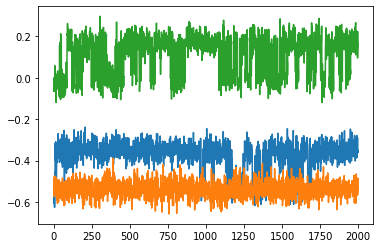

In [185]:
plt.plot(batch['signal'][0])
plt.plot(batch['signal'][1])
plt.plot(batch['signal'][2])
plt.show()

# Load Model

In [186]:
import models.FCC as FCC
from importlib import reload
reload(FCC)

model = FCC.OpenChannelsClassifier(1)
model.apply(FCC.weights_init)
print(sum(p.numel() for p in model.parameters()))
model.to(device)

1173003


OpenChannelsClassifier(
  (fc): Sequential(
    (0): Linear(in_features=2000, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=64, out_features=11, bias=True)
  )
)

In [187]:
model(batch['signal'].to(device).float()).shape

torch.Size([500, 11])

# Optimirez and Criterion Loss

In [188]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [189]:
train_losses = np.array([])
train_accurasy = np.array([])

# Training Loop

In [190]:
num_epochs = 3
monit_res = 500
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()
        
        signal, labels = batch['signal'], batch['open_channels']
        signal = signal.to(device).float()
        labels = labels.to(device).float()
        output = model(signal)
        
        loss = criterion(output, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()        
        
        running_loss += loss.item()
        
        
        if i%monit_res == monit_res-1:
            model.eval()
            predicted_idx = torch.max(output, 1)[1]
            true_idx = torch.max(labels, 1)[1]
            accurasy = sum(true_idx == predicted_idx).item()/len(true_idx)            
            train_accurasy = np.append(train_accurasy, accurasy)

            
            
            train_losses = np.append(train_losses, running_loss/monit_res)
            print('[{}/{}] [{}/{}], loss: {}, accyrasy: {}'.format(epoch,
                                                     num_epochs,
                                                     i,
                                                     len(dataloader),
                                                     round(running_loss/monit_res, 4),
                                                     round(accurasy, 4)
                                                    )
                 )
            running_loss = 0.0

[0/3] [499/10000], loss: 1.5376, accyrasy: 0.476
[0/3] [999/10000], loss: 1.1564, accyrasy: 0.606
[0/3] [1499/10000], loss: 0.9609, accyrasy: 0.632
[0/3] [1999/10000], loss: 0.8571, accyrasy: 0.684
[0/3] [2499/10000], loss: 0.7826, accyrasy: 0.708
[0/3] [2999/10000], loss: 0.7226, accyrasy: 0.658
[0/3] [3499/10000], loss: 0.6864, accyrasy: 0.694
[0/3] [3999/10000], loss: 0.6505, accyrasy: 0.76
[0/3] [4499/10000], loss: 0.6241, accyrasy: 0.774
[0/3] [4999/10000], loss: 0.6114, accyrasy: 0.78
[0/3] [5499/10000], loss: 0.5922, accyrasy: 0.774
[0/3] [5999/10000], loss: 0.5863, accyrasy: 0.78
[0/3] [6499/10000], loss: 0.5754, accyrasy: 0.79
[0/3] [6999/10000], loss: 0.5634, accyrasy: 0.786
[0/3] [7499/10000], loss: 0.5556, accyrasy: 0.774
[0/3] [7999/10000], loss: 0.5638, accyrasy: 0.79
[0/3] [8499/10000], loss: 0.5481, accyrasy: 0.768
[0/3] [8999/10000], loss: 0.5418, accyrasy: 0.8
[0/3] [9499/10000], loss: 0.5421, accyrasy: 0.794
[0/3] [9999/10000], loss: 0.5297, accyrasy: 0.806
[1/3] [49

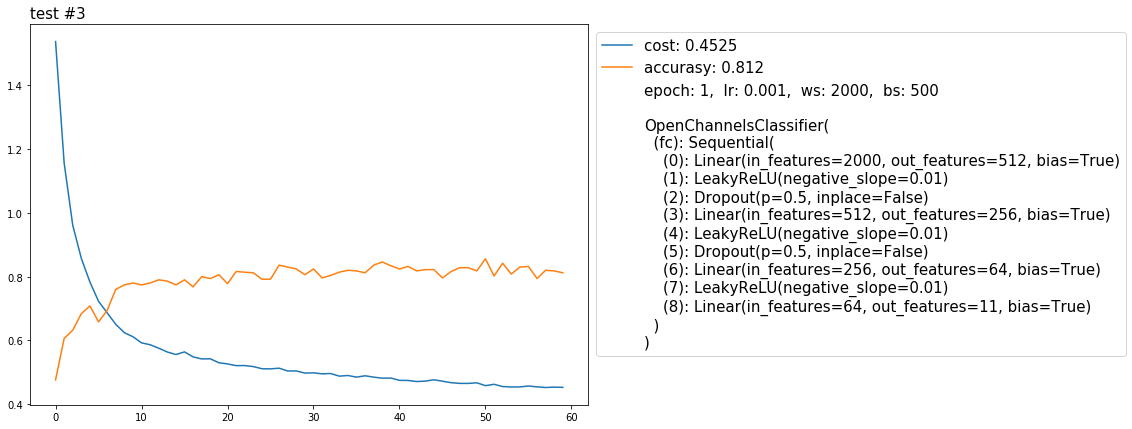

In [191]:
plt.figure(figsize=(10,7))
plt.plot(train_losses, label='cost: {}'.format(round(train_losses[-1], 4)))
plt.plot(train_accurasy, label='accurasy: {}'.format(accurasy))
plt.plot([], [], ' ', label="epoch: 1,  lr: {},  ws: {},  bs: {}\n\n{}".format(lr, ws, btch_sz, model))
plt.title('test #3', fontsize=15, loc='left')
plt.legend(fontsize=15, bbox_to_anchor=(1, 1))
plt.show()

# Prediction

In [158]:
model.eval()
prediction = torch.tensor([]).to(device)
for i, batch in enumerate(dataloader_test):
    
    signal = batch['signal']
    signal = signal.to(device).float()
    
    with torch.no_grad():
        output = model(signal)
  
    
    predicted_idx = torch.max(output, 1)[1]
    prediction = torch.cat((prediction, predicted_idx.float()), 0)
    
    if i%50 == 49:
        print('[{}/{}]'.format(i, len(dataloader_test)))

[49/15625]
[99/15625]
[149/15625]
[199/15625]
[249/15625]
[299/15625]
[349/15625]
[399/15625]
[449/15625]
[499/15625]
[549/15625]
[599/15625]
[649/15625]
[699/15625]
[749/15625]
[799/15625]
[849/15625]
[899/15625]
[949/15625]
[999/15625]
[1049/15625]
[1099/15625]
[1149/15625]
[1199/15625]
[1249/15625]
[1299/15625]
[1349/15625]
[1399/15625]
[1449/15625]
[1499/15625]
[1549/15625]
[1599/15625]
[1649/15625]
[1699/15625]
[1749/15625]
[1799/15625]
[1849/15625]
[1899/15625]
[1949/15625]
[1999/15625]
[2049/15625]
[2099/15625]
[2149/15625]
[2199/15625]
[2249/15625]
[2299/15625]
[2349/15625]
[2399/15625]
[2449/15625]
[2499/15625]
[2549/15625]
[2599/15625]
[2649/15625]
[2699/15625]
[2749/15625]
[2799/15625]
[2849/15625]
[2899/15625]
[2949/15625]
[2999/15625]
[3049/15625]
[3099/15625]
[3149/15625]
[3199/15625]
[3249/15625]
[3299/15625]
[3349/15625]
[3399/15625]
[3449/15625]
[3499/15625]
[3549/15625]
[3599/15625]
[3649/15625]
[3699/15625]
[3749/15625]
[3799/15625]
[3849/15625]
[3899/15625]
[3949/15

In [159]:
prediction = prediction.cpu().detach().numpy()

In [160]:
np.save('prediction/prediction', prediction)